## 1 Overview
An enviroment to train and evaluate neural networks on learning logical consequence.

In [1]:
# For Google Collab: Get repository and go to it in collab.
!git clone -b new-cleaned-branch https://github.com/stereifberger/master-s-thesis
%cd master-s-thesis/

Cloning into 'master-s-thesis'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 399 (delta 239), reused 342 (delta 194), pack-reused 0
Receiving objects: 100% (399/399), 17.31 MiB | 11.20 MiB/s, done.
Resolving deltas: 100% (239/239), done.
/content/master-s-thesis


In [ ]:
# Google Colab if above does not move to right directory
%cd /content/master-s-thesis/

/content/master-s-thesis


In [ ]:
# For VsCode after starting Jupyter server: go to right directory.
%cd master-s-thesis/

/home/str/master-s-thesis


/home/str/environments/general/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
# Install required dependencies - not necessary on google colab
!pip install -r requirements.txt

In [2]:
# Import required libraries
from imports import *

In [5]:
# For reloading libraries.
importlib.reload(generation)

<module 'generation' from '/content/master-s-thesis/generation.py'>

## 2 Create dataset
First the dataset for training is generated. For this the function "create_dataset" from "generation.py" utilizes the functions "gen_outp_PA" to generate a set of random starting formulas, for which iterativly the applicability of rules is checked. All applicable rules are then used to generate new derivations. In each iteration of gen_oupt_PA, set by the iterations variable, new, longer examples are generated.

**Rules.** The rules are defined in calculi.py. Two sets are avaiable: Intuitionistic propositional logic (set below via "calculus = ipl") and classical propositional logic (set below via "calculus = cpl").

**Dataset entries.**
- **x_train.** Training input: [INDEX, PREMISES, DERIVATION SYMBOL, CONCLUSION]
- **y_train_ordered.** Dataset of correct derivations where each sublist i correspnds to INDEX: [DERIVATIONS_0...DERIVATION_N]

**Encoding.** Propositional variables and logical constants are encoded as integers. The integers are then one-hot-encoded into unique sequences containing only 0s and ones with the length of the maximum integer value, the feature length. The shape of the individual entries is 2D: [SEQUENCE LENGTH, FEATURE LENGTH].

**Example entries withouth numerical representation and one-hot-encoding.**
- **x_train.** [2345, A, A THEN B, DERIVES, B OR C]
- **y_train_ordered.** Sublist 2345 is entry entry: [[A, A THEN B, B, B OR C], [A, A THEN B, B, A AND B, B OR C]]


In [3]:
import contextlib
import io

In [ ]:
# Create dataset
x_train_2d, x_train_3d, y_train_ordered, max_y_train_len = generation.create_dataset(iterations = [1,2], calculus = calculi.cl)

Processed at iteration 1:   0%|          | 0/2000 [00:00<?, ?it/s]

Processed at iteration 2:   0%|          | 0/11500 [00:00<?, ?it/s]

Processed premises for sample conclusions at iteration 2:   0%|          | 0/13663 [00:00<?, ?it/s]

Checked derivations for sample conclusions:   0%|          | 0/165044 [00:00<?, ?it/s]

Padded x_train entries:   0%|          | 0/107204 [00:00<?, ?it/s]

  0%|          | 0/107204 [00:00<?, ?it/s]

Processed entries for x_train and y_tdict:   0%|          | 0/107204 [00:00<?, ?it/s]

Padded y_train_ordered:   0%|          | 0/52260 [00:00<?, ?it/s]

Padded x_train entries:   0%|          | 0/52260 [00:00<?, ?it/s]

LENINPT: 52260
LENy_t: 52260
Number x_train examples: 52260
Average number ground truth examples/x_train example: 2.0513585916570993


In [ ]:
import json
torch.save(x_train_2d, 'x_train_2d.pt')
torch.save(x_train_3d, 'x_train_3d.pt')
torch.save(y_train_ordered, 'y_train_ordered.pt')
with open('Medium_max_y_train_len.json', 'w') as file:
    json.dump(max_y_train_len, file)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
# prompt: Import files from drive folder
!cp /content/drive/MyDrive/university/masters_thesis/datasets/2000-1-2/x_train_2d.pt /content
!cp /content/drive/MyDrive/university/masters_thesis/datasets/2000-1-2/x_train_3d.pt /content
!cp /content/drive/MyDrive/university/masters_thesis/datasets/2000-1-2/y_train_ordered.pt /content
!cp /content/drive/MyDrive/university/masters_thesis/datasets/2000-1-2/Medium_max_y_train_len.json /content


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# prompt: Define variables x_train_2d, x_train_3d and y_train_ordered on the respective files.

with open('/content/x_train_2d.pt', 'rb') as f:
    x_train_2d = torch.load(f)

with open('/content/x_train_3d.pt', 'rb') as f:
    x_train_3d = torch.load(f)

with open('/content/y_train_ordered.pt', 'rb') as f:
    y_train_ordered = torch.load(f)


In [11]:
# prompt: Define variable max_y_train_len on Medium_max_y_train_len.json

import json

with open('/content/Medium_max_y_train_len.json', 'r') as file:
    max_y_train_len = json.load(file)


In [12]:
max_y_train_len

1008

## 3 Prepare dataset and define models for training
Next with pytorch's dataloader the single training entries in x_train are assigned to batches of size "batch size" in mixed order. Then the different models are defined using definitions from "architectures.py". These models are:

- Feedforward network (net)
- Recurrent neural network (RNNNet)
- Long-short-term memory (LSTMNet)
- Transformers (TransformerModel)

In [ ]:
# Use when gpu is present to empty its catch and define it as "device" for referencing it
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Get the datasets' shapes for the model definitions later
two_d_shape = x_train_2d.shape
three_d_shape = x_train_3d.shape
max_y_length = int(max_y_train_len/14)

In [ ]:
# Reverse one-hot encoding for encoder-decoder models
x = torch.argmax(x_train_3d, dim=2)
x[:, 0] = x_train_2d[:, 0]
x_train_nu = x

In [ ]:
# Set train-test split to 80-20 [^1]
train_size = int(0.8 * len(x_train_2d))
test_size = len(x_train_2d) - train_size
x_train_2d, x_test_2d = random_split(x_train_2d, [train_size, test_size])
x_train_3d, x_test_3d = random_split(x_train_3d, [train_size, test_size])
x_train_nu, x_test_nu = random_split(x_train_nu, [train_size, test_size])

In [ ]:
# Collect and mix the data in [^2]
train_dataloader_2d = DataLoader(dataset = x_train_2d, shuffle = True, batch_size = 16)
test_dataloader_2d = DataLoader(dataset = x_test_2d, shuffle = True, batch_size = 16)
train_dataloader_3d = DataLoader(dataset = x_train_3d, shuffle = True, batch_size = 16)
test_dataloader_3d = DataLoader(dataset = x_test_3d, shuffle = True, batch_size = 16)
train_dataloader_nu = DataLoader(dataset = x_train_nu, shuffle = True, batch_size = 64)
test_dataloader_nu = DataLoader(dataset = x_test_nu, shuffle = True, batch_size = 64)

In [ ]:
# Load ground truth data to GPU
y_train = y_train_ordered.to(device)
y_train_3d = y_train.view(int(len(y_train)), int(len(y_train[0])), int(len(y_train[0][0])/14), 14)

In [ ]:
# Define the Encoder-Decoder networks
## FFN | Inputs: input_dim, hidden dim
encoder_ffn = architectures.Encoder_FFN(three_d_shape[1], 20)
decoder_ffn = architectures.Decoder_FFN((max_y_length*14), 20)
ffn_ed_model = architectures.Seq2Seq(encoder_ffn, decoder_ffn, device)
## RNN | Inputs: input_dim, embedding dim, hidden dim, nr layers
#encoder_rnn = architectures.Encoder_RNN(three_d_shape[1], 128, 150, 1)
#decoder_rnn = architectures.Decoder_RNN(14, 128, 150, 3)
#rnn_ed_model = architectures.Seq2Seq(encoder_rnn, decoder_rnn, device)
## LSTM | Inputs: input_dim, embedding dim, hidden dim, nr layers, droput
encoder_lstm = architectures.Encoder_LSTM(three_d_shape[1], 128, 256, 2, 0)
decoder_lstm = architectures.Decoder_LSTM(14, 256, 256, 2, 0)
lst_ed_model = architectures.Seq2Seq(encoder_lstm, decoder_lstm, device)
## Transformer-Encoder | Inputs:  input_dim, emb_dim, num_heads, hidden_dim, num_layers, dropout
encoder_tra = architectures.TransformerEncoder(three_d_shape[1], 128, 4, 256, 2, dropout=0)
# Transformer-Decoder | Inputs: output_dim, emb_dim, num_heads, hidden_dim, num_layers
decoder_tra = architectures.TransformerDecoder(14, 256, 4, 256, 2)
tra_ed_model = architectures.Seq2SeqTransformer(encoder_tra, decoder_tra, device)

# Define optimizers for models
lr = 0.001
ffn_ed_optimizer = torch.optim.AdamW(ffn_ed_model.parameters(),lr=lr)
rnn_ed_optimizer = torch.optim.AdamW(rnn_ed_model.parameters(),lr=lr)
lst_ed_optimizer = torch.optim.AdamW(lst_ed_model.parameters(),lr=lr)
tra_ed_optimizer = torch.optim.AdamW(tra_ed_model.parameters(),lr=lr)

# 4 Training

In [ ]:
import csv

In [ ]:
import contextlib
import io

In [ ]:
criterion = nn.CrossEntropyLoss()

## 4.1 FFN Encoder-Decoder

In [ ]:
# Load model to GPU
ffn_ed_model.to(device)

Seq2Seq(
  (encoder): Encoder_FFN(
    (embedding): Embedding(55, 20)
    (fc_hidden): Linear(in_features=20, out_features=20, bias=True)
  )
  (decoder): Decoder_FFN(
    (fc_hidden): Linear(in_features=20, out_features=20, bias=True)
    (fc_out): Linear(in_features=20, out_features=1008, bias=True)
  )
)

In [ ]:
x_train_nu_2 = [x_train_nu[i][1:].tolist() for i in range(len(x_train_nu))]

In [ ]:
# Train model and save results
FFN_CELtrain, FFN_CELtest, FFN_ACCtrain, FFN_ACCtest = schedule.train_model(ffn_ed_model, train_dataloader_nu, test_dataloader_nu, ffn_ed_optimizer, criterion, 20, device, max_y_length, y_train)
torch.save(ffn_ed_model.state_dict(), 'ffn_2l.pth')

Ep. 01, CEL-Train: 377.1100| CEL-Test: 367.4432 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 02, CEL-Train: 364.9277| CEL-Test: 364.2587 | ACC-Train: 0.0000 | ACC-Test:  0.0500
Ep. 03, CEL-Train: 363.9621| CEL-Test: 364.0389 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 04, CEL-Train: 363.8176| CEL-Test: 363.8662 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 05, CEL-Train: 363.5521| CEL-Test: 363.4199 | ACC-Train: 0.0625 | ACC-Test:  0.0000
Ep. 06, CEL-Train: 362.7582| CEL-Test: 362.4800 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 07, CEL-Train: 361.8980| CEL-Test: 361.7068 | ACC-Train: 0.0625 | ACC-Test:  0.0000
Ep. 08, CEL-Train: 361.3448| CEL-Test: 361.3458 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 09, CEL-Train: 360.8822| CEL-Test: 360.8793 | ACC-Train: 0.0625 | ACC-Test:  0.1500
Ep. 10, CEL-Train: 360.5527| CEL-Test: 360.5707 | ACC-Train: 0.0000 | ACC-Test:  0.1000
Ep. 11, CEL-Train: 360.2291| CEL-Test: 360.1036 | ACC-Train: 0.0000 | ACC-Test:  0.0500
Ep. 12, CEL-Train: 359.7205| CEL

In [ ]:
# prompt: convert FFN_CELtrain to a list

FFN_CELtrain_list = list(FFN_CELtrain)


[377.1099521275325,
 364.9277030641515,
 363.9621202661357,
 363.81762331341383,
 363.552097845515,
 362.75820409558963,
 361.8980101605803,
 361.3447757452635,
 360.8821592185111,
 360.5526848655957,
 360.22905574880247,
 359.72046948354176,
 359.3023719904255,
 358.83163209501026,
 358.4711538425644,
 358.2835426447224,
 358.2102163238992,
 358.1684285201793,
 358.10023162561816,
 357.98913961521345]

In [ ]:
def csv_saver(list_a, list_b, list_a_name, list_b_name, name):
  # Generate the "Iterations" list
  Iterations = list(range(1, len(list_a) + 1))

  # Writing to csv file
  with open(name, mode='w', newline='') as file:
      writer = csv.writer(file)

      # Writing the header
      writer.writerow(["Iterations", list_a_name, list_b_name])

      # Writing the data rows
      for i in range(len(list_a)):
          writer.writerow([Iterations[i], list_a[i], list_b[i]])

  print(f'Data successfully written to {name}')

In [ ]:
input, output = schedule.sanity(ffn_ed_model, test_dataloader_nu, device, max_y_length)

In [ ]:
csv_saver(FFN_CELtrain, FFN_CELtest, "CELtrain", "CELtest", "FFN_small_CEL.csv")

Data successfully written to FFN_small_CEL.csv


In [ ]:
csv_saver(FFN_ACCtrain, FFN_ACCtest, "ACCtrain", "ACCtest", "FFN_small_ACC.csv")

Data successfully written to FFN_small_ACC.csv


In [ ]:
csv_saver(input, output, "input", "output", "FFN_small_sanity.csv")

Data successfully written to FFN_small_sanity.csv


In [ ]:
# Delete model from GPU to make space for new models
del ffn_ed_model
torch.cuda.empty_cache()

## 4.2 RNN Encoder-Decoder

In [ ]:
# Load model to GPU
rnn_ed_model.to(device)

Seq2Seq(
  (encoder): Encoder_RNN(
    (embedding): Embedding(55, 150)
    (rnn): RNN(150, 150, batch_first=True)
  )
  (decoder): Decoder_RNN(
    (rnn): RNN(150, 150, num_layers=3, batch_first=True)
    (fc_out): Linear(in_features=150, out_features=14, bias=True)
  )
)

In [ ]:
# Training Loop
RNN_CELtrain, RNN_CELtest, RNN_ACCtrain, RNN_ACCtest = schedule.train_model(rnn_ed_model, train_dataloader_nu, test_dataloader_nu, rnn_ed_optimizer, criterion, 50, device, max_y_length, y_train_3d)
torch.save(rnn_ed_model.state_dict(), 'addition_model.pth')

Ep. 01, CEL-Train: 1.2988| CEL-Test: 1.2971 | ACC-Train: 0.6876 | ACC-Test:  0.7120
Ep. 02, CEL-Train: 1.2661| CEL-Test: 1.2422 | ACC-Train: 0.7020 | ACC-Test:  0.7069
Ep. 03, CEL-Train: 1.2508| CEL-Test: 1.2511 | ACC-Train: 0.6745 | ACC-Test:  0.7014
Ep. 04, CEL-Train: 1.2465| CEL-Test: 1.2575 | ACC-Train: 0.7232 | ACC-Test:  0.6824
Ep. 05, CEL-Train: 1.2570| CEL-Test: 1.2459 | ACC-Train: 0.7048 | ACC-Test:  0.6991
Ep. 06, CEL-Train: 1.2499| CEL-Test: 1.2334 | ACC-Train: 0.6972 | ACC-Test:  0.7000
Ep. 07, CEL-Train: 1.2199| CEL-Test: 1.2507 | ACC-Train: 0.7215 | ACC-Test:  0.6824
Ep. 08, CEL-Train: 1.2461| CEL-Test: 1.2509 | ACC-Train: 0.6793 | ACC-Test:  0.6843
Ep. 09, CEL-Train: 1.2308| CEL-Test: 1.2429 | ACC-Train: 0.6828 | ACC-Test:  0.6866
Ep. 10, CEL-Train: 1.2283| CEL-Test: 1.2242 | ACC-Train: 0.6848 | ACC-Test:  0.7046
Ep. 11, CEL-Train: 1.0848| CEL-Test: 0.8920 | ACC-Train: 0.7114 | ACC-Test:  0.7014
Ep. 12, CEL-Train: 0.8823| CEL-Test: 0.8821 | ACC-Train: 0.7159 | ACC-Test: 

In [ ]:
# A sanity test for wheter the outputs look appropriate
schedule.sanity(rnn_ed_model, test_dataloader_nu, device, max_y_length)

INPUT: ((q∧s)r)⊢(r∨q)
OUTPUT: (
INPUT: (p(p∨r))⊢(q∨p)
OUTPUT: (
INPUT: ((q∧q)(¬s))⊢(q∨(q∧q))
OUTPUT: (
INPUT: ((s→(r∧q))(r∧q))⊢(r∨q)
OUTPUT: (
INPUT: (t((r∨s)∨r))⊢t
OUTPUT: (
INPUT: (r(s→(q∧p)))⊢(r→(r∨r))
OUTPUT: (
INPUT: (((q→t)∨q)q)⊢(((q→t)∨q)∧q)
OUTPUT: (
INPUT: ((r∨p)((p∨q)→t))⊢((r∨p)∨r)
OUTPUT: (
INPUT: (((t∧t)→q)p)⊢(p∨p)
OUTPUT: (
INPUT: (r(¬s))⊢(t∨((¬s)∨q))
OUTPUT: (
INPUT: (r(t→s))⊢(r∨p)
OUTPUT: (
INPUT: (r((q→q)∧r))⊢(r→(r∨r))
OUTPUT: (
INPUT: ((p∧q)(t∧p))⊢((p∧q)∨q)
OUTPUT: (
INPUT: ((q∧(¬r))(¬r))⊢((q∧(¬r))∨q)
OUTPUT: (
INPUT: ((t∧r)(¬s))⊢((¬s)∨r)
OUTPUT: (
INPUT: (p(p∨p))⊢(p∧(p∨s))
OUTPUT: (
INPUT: (s(t∧(¬p)))⊢(s∧(s∨q))
OUTPUT: (
INPUT: (((q∧q)→r)t)⊢(p∨t)
OUTPUT: (
INPUT: ((q→r)(¬s))⊢((q∨(¬s))∨t)
OUTPUT: (
INPUT: ((s∧p)(s∧(r→t)))⊢((s∧p)∧((s∧p)∨r))
OUTPUT: (
INPUT: (((t→s)∨q)(r∧p))⊢(((t→s)∨q)∨q)
OUTPUT: (
INPUT: ((t∧s)s)⊢(s→(s∨s))
OUTPUT: (
INPUT: (r(t→s))⊢((t→s)∨p)
OUTPUT: (
INPUT: (s(r∧t))⊢t
OUTPUT: (
INPUT: (t(p∧r))⊢(r∨r)
OUTPUT: (
INPUT: (r((q∨t)→p))⊢(t∨(t∨r))
OUTPUT: (
INP

In [ ]:
# Delete model from GPU to make space for new models
del rnn_ed_model
torch.cuda.empty_cache()

## 4.3 LSTM Encoder-Decoder

In [ ]:
# Load model to GPU
lst_ed_model.to(device)

Seq2Seq(
  (encoder): Encoder_LSTM(
    (embedding): Embedding(55, 128)
    (rnn): LSTM(128, 256, num_layers=2, batch_first=True)
  )
  (decoder): Decoder_LSTM(
    (rnn): LSTM(256, 256, num_layers=2, batch_first=True)
    (fc_out): Linear(in_features=256, out_features=14, bias=True)
  )
)

In [ ]:
# Training Loop
LSTM_CELtrain, LSTM_CELtest, LSTM_ACCtrain, LSTM_ACCtest = schedule.train_model(lst_ed_model, train_dataloader_nu, test_dataloader_nu, lst_ed_optimizer, criterion, 100, device, max_y_length, y_train_3d)
torch.save(lst_ed_model.state_dict(), 'addition_model.pth')

Ep. 01, CEL-Train: 0.9360| CEL-Test: 0.8494 | ACC-Train: 0.7543 | ACC-Test:  0.7507
Ep. 02, CEL-Train: 0.7572| CEL-Test: 0.7417 | ACC-Train: 0.7630 | ACC-Test:  0.7583
Ep. 03, CEL-Train: 0.7096| CEL-Test: 0.7039 | ACC-Train: 0.7691 | ACC-Test:  0.7653
Ep. 04, CEL-Train: 0.6456| CEL-Test: 0.6113 | ACC-Train: 0.7856 | ACC-Test:  0.7833
Ep. 05, CEL-Train: 0.5448| CEL-Test: 0.5238 | ACC-Train: 0.8125 | ACC-Test:  0.8174
Ep. 06, CEL-Train: 0.5000| CEL-Test: 0.4911 | ACC-Train: 0.8238 | ACC-Test:  0.7972
Ep. 07, CEL-Train: 0.4608| CEL-Test: 0.4450 | ACC-Train: 0.8429 | ACC-Test:  0.8451
Ep. 08, CEL-Train: 0.4295| CEL-Test: 0.4218 | ACC-Train: 0.8325 | ACC-Test:  0.8076
Ep. 09, CEL-Train: 0.4136| CEL-Test: 0.4030 | ACC-Train: 0.8151 | ACC-Test:  0.8625
Ep. 10, CEL-Train: 0.3989| CEL-Test: 0.3843 | ACC-Train: 0.8229 | ACC-Test:  0.8569
Ep. 11, CEL-Train: 0.3864| CEL-Test: 0.3785 | ACC-Train: 0.8385 | ACC-Test:  0.8819
Ep. 12, CEL-Train: 0.3817| CEL-Test: 0.3739 | ACC-Train: 0.8655 | ACC-Test: 

In [ ]:
input, output = schedule.sanity(lst_ed_model, test_dataloader_nu, device, max_y_length)

In [ ]:
csv_saver(LSTM_CELtrain, LSTM_CELtest, "CELtrain", "CELtest", "LSTM_small_CEL.csv")

Data successfully written to LSTM_small_CEL.csv


In [ ]:
csv_saver(LSTM_ACCtrain, LSTM_ACCtest, "ACCtrain", "ACCtest", "LSTM_small_ACC.csv")

Data successfully written to LSTM_small_ACC.csv


In [ ]:
csv_saver(input, output, "input", "output", "LSTM_small_sanity.csv")

Data successfully written to LSTM_small_sanity.csv


In [ ]:
# Delete model from GPU to make space for new models
del lst_ed_model
torch.cuda.empty_cache()

## 4.4 Transformer

In [ ]:
importlib.reload(schedule)

In [ ]:
# Load model to GPU
tra_ed_model.to(device)

Seq2SeqTransformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(55, 150)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=150, out_features=150, bias=True)
          )
          (linear1): Linear(in_features=150, out_features=150, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=150, out_features=150, bias=True)
          (norm1): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
      )
    )
  )
  (decoder): TransformerDecoder(
    (embedding): Embedding(14, 150)
    (transformer_decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Transfo

In [ ]:
TRA_CELtrain, TRA_CELtest, TRA_ACCtrain, TRA_ACCtest = schedule.train_model(tra_ed_model, train_dataloader_nu, test_dataloader_nu, tra_ed_optimizer, criterion, 50, device, max_y_length, y_train_3d)
torch.save(tra_ed_model.state_dict(), 'addition_model.pth')

Ep. 01, CEL-Train: 0.7941| CEL-Test: 0.6965 | ACC-Train: 0.7538 | ACC-Test:  0.7630
Ep. 02, CEL-Train: 0.4696| CEL-Test: 0.3393 | ACC-Train: 0.8631 | ACC-Test:  0.9417
Ep. 03, CEL-Train: 0.3164| CEL-Test: 0.2658 | ACC-Train: 0.8806 | ACC-Test:  0.9000
Ep. 04, CEL-Train: 0.2654| CEL-Test: 0.2326 | ACC-Train: 0.9010 | ACC-Test:  0.9204
Ep. 05, CEL-Train: 0.2372| CEL-Test: 0.2132 | ACC-Train: 0.8975 | ACC-Test:  0.9343
Ep. 06, CEL-Train: 0.2191| CEL-Test: 0.1983 | ACC-Train: 0.9247 | ACC-Test:  0.9269
Ep. 07, CEL-Train: 0.2072| CEL-Test: 0.1830 | ACC-Train: 0.9091 | ACC-Test:  0.9481
Ep. 08, CEL-Train: 0.1974| CEL-Test: 0.1799 | ACC-Train: 0.9348 | ACC-Test:  0.8972
Ep. 09, CEL-Train: 0.1891| CEL-Test: 0.1744 | ACC-Train: 0.9336 | ACC-Test:  0.9435
Ep. 10, CEL-Train: 0.1816| CEL-Test: 0.1696 | ACC-Train: 0.9369 | ACC-Test:  0.9356
Ep. 11, CEL-Train: 0.1761| CEL-Test: 0.1612 | ACC-Train: 0.9013 | ACC-Test:  0.9301
Ep. 12, CEL-Train: 0.1726| CEL-Test: 0.1603 | ACC-Train: 0.9379 | ACC-Test: 

In [ ]:
input, output = schedule.sanity(tra_ed_model, test_dataloader_nu, device, max_y_length)

In [ ]:
csv_saver(TRA_CELtrain, TRA_CELtest, "CELtrain", "CELtest", "TRA_small_CEL.csv")

Data successfully written to FFN_small_CEL.csv


In [ ]:
csv_saver(TRA_ACCtrain, TRA_ACCtest, "ACCtrain", "ACCtest", "TRA_small_ACC.csv")

Data successfully written to FFN_small_ACC.csv


In [ ]:
csv_saver(input, output, "input", "output", "TRA_small_sanity.csv")

Data successfully written to FFN_small_sanity.csv


In [ ]:
# A sanity test for wheter the outputs look appropriate
schedule.sanity(tra_ed_model, test_dataloader_nu, device, max_y_length)

INPUT: (((¬r)∧q)s)⊢(((¬r)∧q)∧q)
OUTPUT: ((¬r)∧q)s(((¬r)∧q)∧s)
INPUT: (r(p∨t))⊢((p∨t)∨p)
OUTPUT: r(p∨t)(r∨(p∨t))((p∨t)∨p)
INPUT: (q(s∨p))⊢((s∨p)∧((s∨p)∨r))
OUTPUT: q(s∨p)((s∨p)∨r)((s∨p)∧((s∨p)∨r))
INPUT: (((p→r)∨s)p)⊢((p→r)∨s)
OUTPUT: ((p→r)∨s)p(((p→r)∨s)∧p)((p→r)∨s)
INPUT: (p((s→t)∨s))⊢((p∨p)∨q)
OUTPUT: p((s→t)∨s)(p∨p)((p∨p)∨q)
INPUT: ((q→p)(q∨t))⊢(q∨(r∨(q→p)))
OUTPUT: (q→p)(q∨t)(r∨(q→p))(q∨(r∨(q→p)))
INPUT: (((p→q)∨r)(¬q))⊢((¬q)→((¬q)∨s))
OUTPUT: ((p→q)∨r)(¬q)((¬p)∨q)((¬q)→((¬q)∨s))
INPUT: (t(q→r))⊢(t∧(q→r))
OUTPUT: t(q→r)(t∧(q→r))
INPUT: (r(p∨p))⊢(r∨t)
OUTPUT: r(p∨p)(r∨(p∨p))(r∨t)
INPUT: (s(r→p))⊢((r→p)∨q)
OUTPUT: s(r→p)(sr→r→p))((r→p)∨q)
INPUT: ((s∧t)(¬r))⊢(q∨t)
OUTPUT: (s∧t)(¬r)t(q∨t)
INPUT: ((q∨t)(q∧s))⊢((q∨t)∨s)
OUTPUT: (q∨t)(q∧s)((q∨t)∨))((q∨t)∨s)
INPUT: ((¬s)q)⊢(t∨(s∨(¬s)))
OUTPUT: (¬s)q(s∨(¬s))(t∨(s∨(¬s)))
INPUT: ((q∧t)(t∧(r→p)))⊢t
OUTPUT: (q∧t)(t∧(r→p))t
INPUT: (((s→r)∧q)t)⊢(t∨(s∨t))
OUTPUT: ((s→r)∧q)t(s∨t)(t∨(s∨t))
INPUT: ((s→p)t)⊢(t∧(p∨t))
OUTPUT: (s→p)t(p∨t)(t∧(p∨t))
INPUT

In [ ]:
# Delete model from GPU to make space for new models
del tra_ed_model
torch.cuda.empty_cache()

## 5 Plot results
Here all results from above are plotted.

In [ ]:
from matplotlib import font_manager as fm

In [ ]:
plt.rcParams['font.family'] = 'serif'

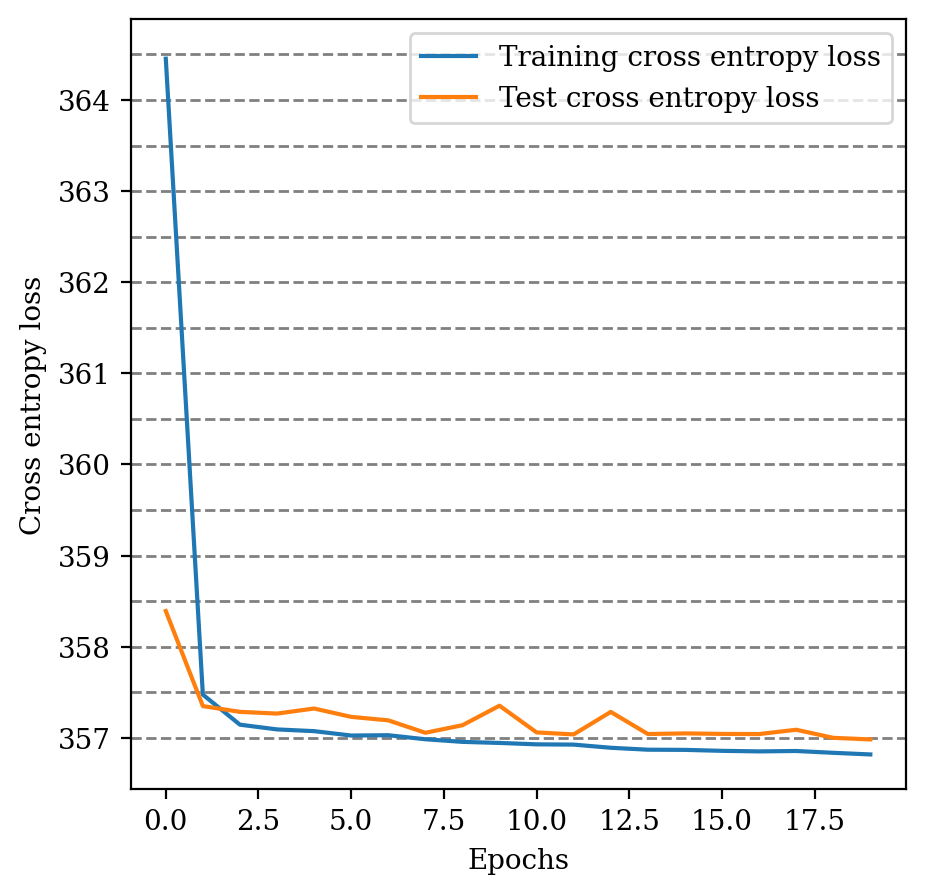

In [ ]:
#Feedforward Network, Non-Deep, Medium Dataset, Cross Entropy Loss
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(20))
for y_value in np.arange(357, 365, 0.5):
    plt.axhline(y=y_value, color='grey', linestyle='--', linewidth=1)
prop = fm.FontProperties(fname='/usr/share/fonts/opentype/freefont/FreeSerif.otf')
plt.plot(x_data, FFN_CELtrain, label='Training cross entropy loss')
plt.plot(x_data, FFN_CELtest, label='Test cross entropy loss')
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.legend()
plt.show()

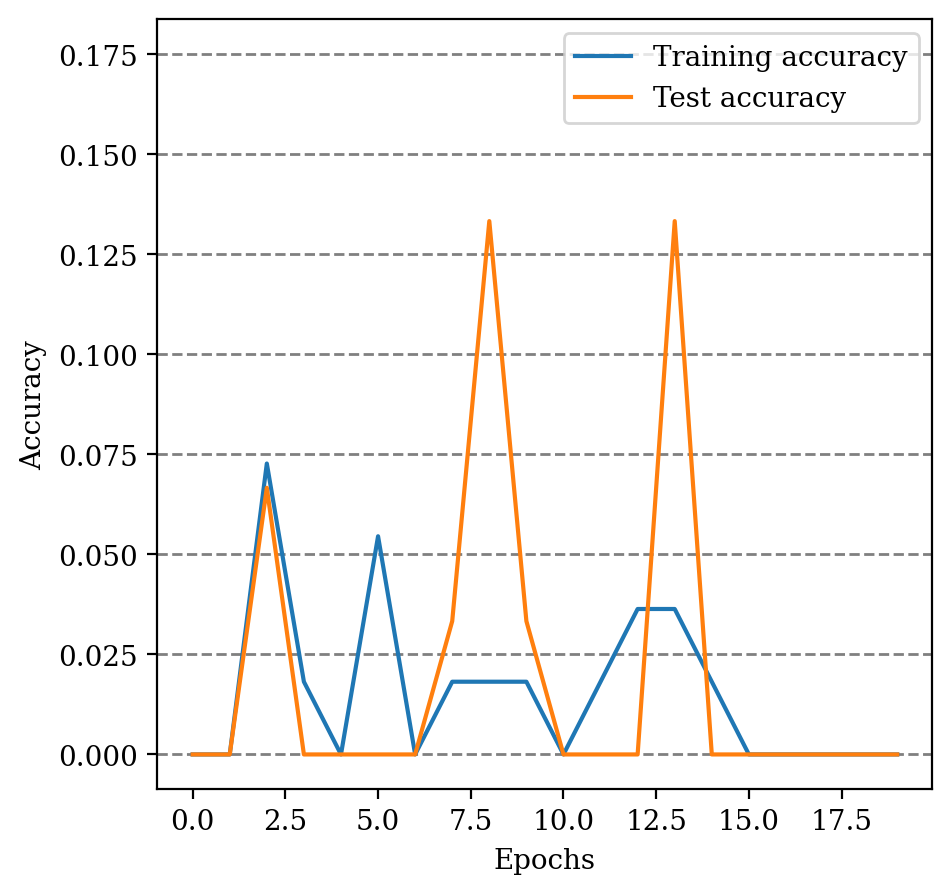

In [ ]:
# Feedforward Network, Non-Deep, Medium Dataset, Accuracy
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(20))
for y_value in np.arange(0, 0.2, 0.025):
    plt.axhline(y=y_value, color='grey', linestyle='--', linewidth=1)
plt.plot(x_data, FFN_ACCtrain, label='Training accuracy')
plt.plot(x_data, FFN_ACCtest, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

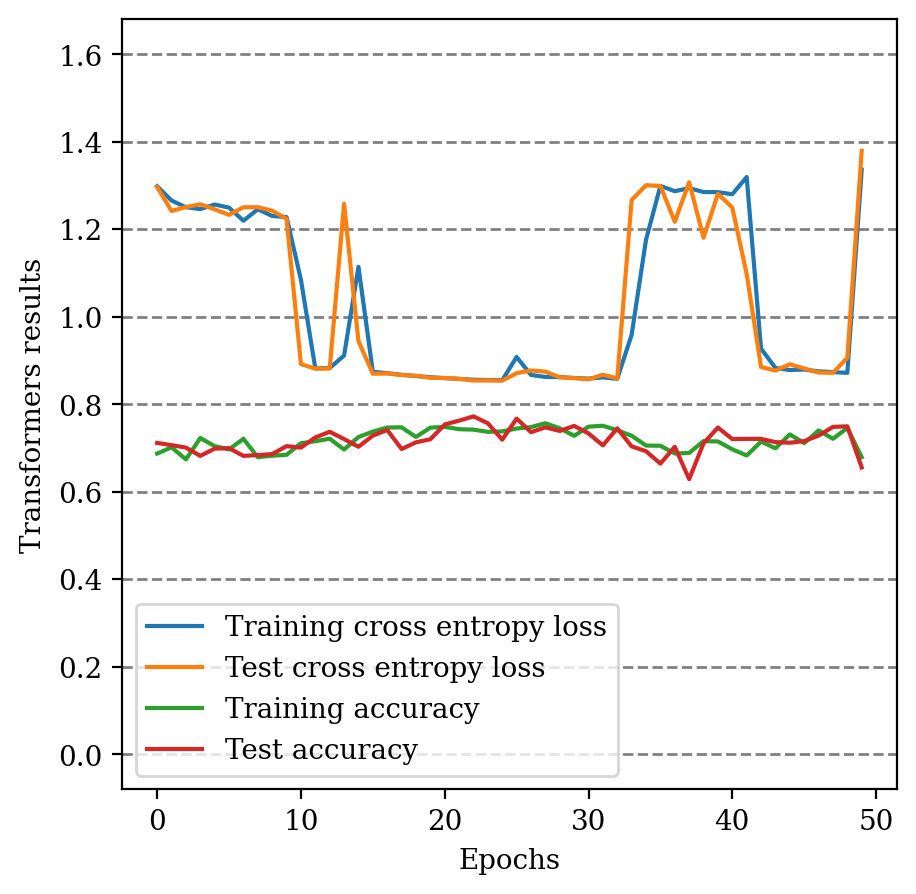

In [ ]:
# Recurrent Neural Network, Medium, Medium Dataset, Accuracy, Cross Entropy Loss
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
for y_value in np.arange(0, 1.8, 0.2):
    plt.axhline(y=y_value, color='grey', linestyle='--', linewidth=1)
plt.plot(x_data, RNN_CELtrain, label='Training cross entropy loss')
plt.plot(x_data, RNN_CELtest, label='Test cross entropy loss')
plt.plot(x_data, RNN_ACCtrain, label='Training accuracy')
plt.plot(x_data, RNN_ACCtest, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()

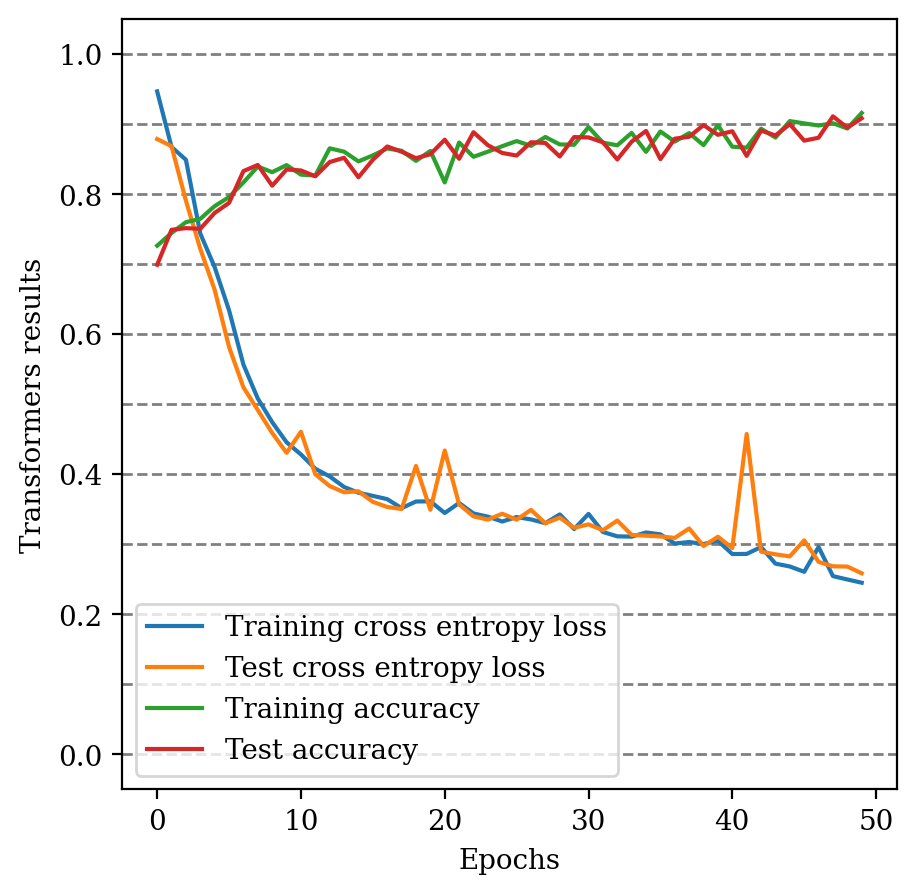

In [ ]:
# Long Short-Term Memory, Medium, Medium Dataset, Accuracy, Cross Entropy Loss
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
for y_value in np.arange(0, 1.1, 0.1):
    plt.axhline(y=y_value, color='grey', linestyle='--', linewidth=1)
plt.plot(x_data, LSTM_CELtrain, label='Training cross entropy loss')
plt.plot(x_data, LSTM_CELtest, label='Test cross entropy loss')
plt.plot(x_data, LSTM_ACCtrain, label='Training accuracy')
plt.plot(x_data, LSTM_ACCtest, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()

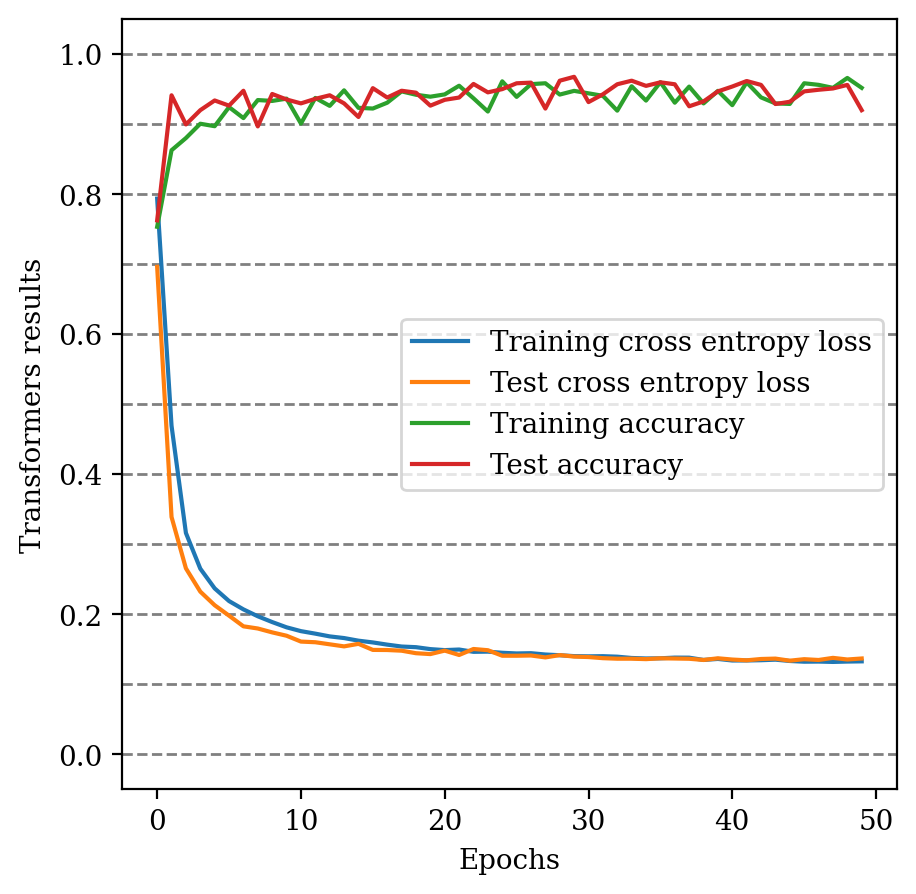

In [ ]:
# Transformer, Medium, Medium Dataset, Accuracy, Cross Entropy Loss
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
for y_value in np.arange(0, 1.1, 0.1):
    plt.axhline(y=y_value, color='grey', linestyle='--', linewidth=1)
plt.plot(x_data, TRA_CELtrain, label='Training cross entropy loss')
plt.plot(x_data, TRA_CELtest, label='Test cross entropy loss')
plt.plot(x_data, TRA_ACCtrain, label='Training accuracy')
plt.plot(x_data, TRA_ACCtest, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()

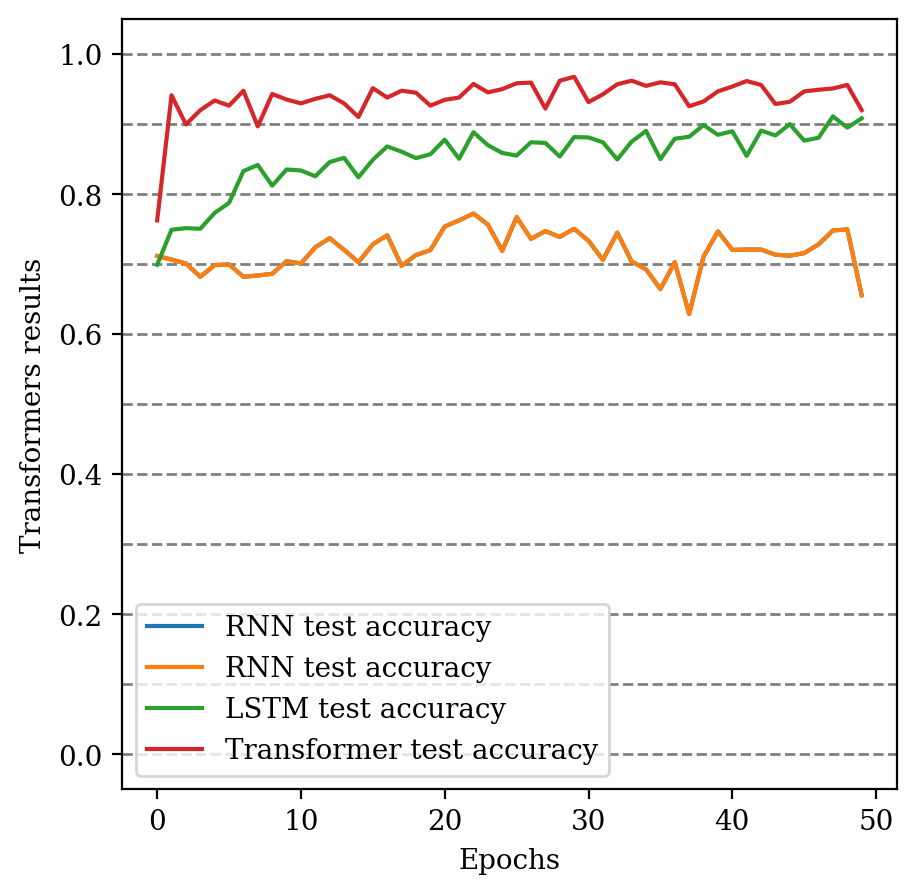

In [ ]:
# Test-Accuracy all Networks, Medium Dataset, Accuracy
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
#plt.plot(x_data, FFN_ACCtest, label='FFN Test accuracy')
for y_value in np.arange(0, 1.1, 0.1):
    plt.axhline(y=y_value, color='grey', linestyle='--', linewidth=1)
plt.plot(x_data, RNN_ACCtest, label='RNN test accuracy')
plt.plot(x_data, RNN_ACCtest, label='RNN test accuracy')
plt.plot(x_data, LSTM_ACCtest, label='LSTM test accuracy')
plt.plot(x_data, TRA_ACCtest, label='Transformer test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()

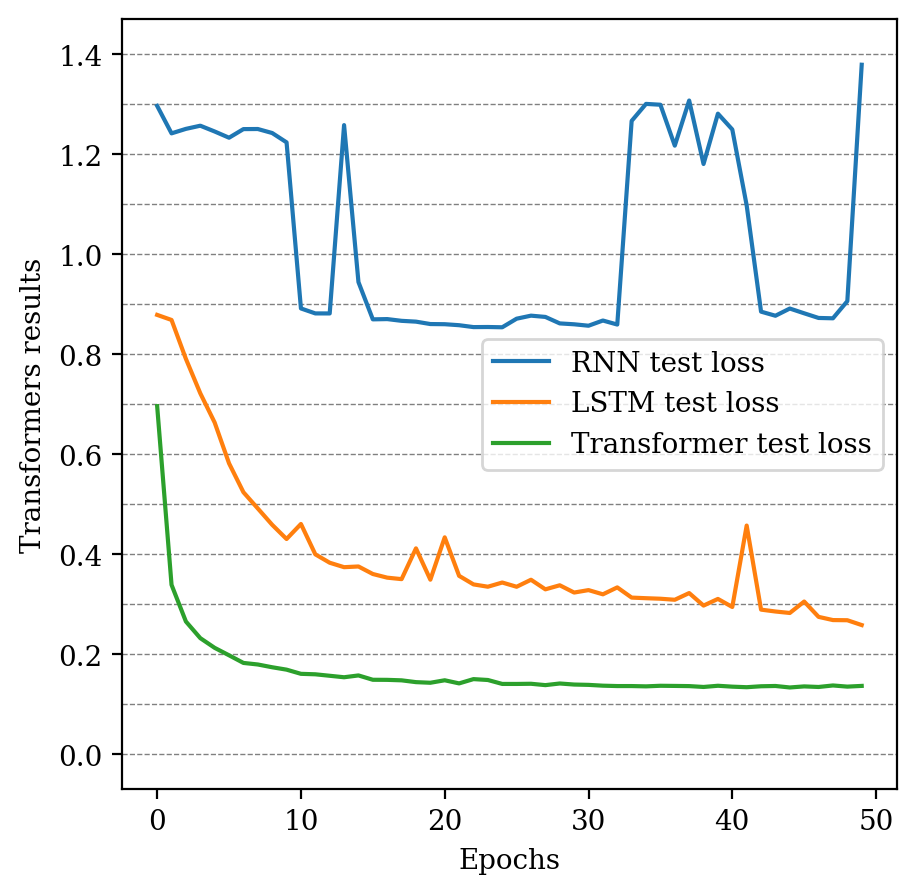

In [ ]:
# Test-Accuracy all Networks, Medium Dataset, Accuracy
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
#plt.plot(x_data, FFN_ACCtest, label='FFN Test accuracy')
for y_value in np.arange(0, 1.5, 0.1):
    plt.axhline(y=y_value, color='grey', linestyle='--', linewidth=0.5)
plt.plot(x_data, RNN_CELtest, label='RNN test loss')
plt.plot(x_data, LSTM_CELtest, label='LSTM test loss')
plt.plot(x_data, TRA_CELtest, label='Transformer test loss')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()